[View in Colaboratory](https://colab.research.google.com/github/stanimman/Simple/blob/master/Copy_of_Mura.ipynb)

In [5]:
!pip uninstall Pillow -y

!pip install Pillow
# Need to restart to get the Pillow version to be changed in 5.2.0

Uninstalling Pillow-4.0.0:
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 7.3MB/s 


In [1]:
import PIL
print(PIL.PILLOW_VERSION)

5.2.0


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import pil_loader
from torchvision import transforms, utils
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from torchvision import  models
import torch.nn as nn
import torch.optim as optim
import copy
from torch.optim import lr_scheduler
import time
import datetime as dt
from PIL import Image

tcmalloc: large alloc 1073750016 bytes == 0x5c41c000 @  0x7f5cfd1f01c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [1]:
#!wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2018-07-15 07:57:47--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380296872 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip         6%[>                   ] 222.90M  13.8MB/s    eta 3m 35s ^C


In [4]:
!wget https://fs7.transfernow.net/download/5b4b0c4045c8d/master/MURA-v1.1.zip

--2018-07-15 17:34:09--  https://fs7.transfernow.net/download/5b4b0c4045c8d/master/MURA-v1.1.zip
Resolving fs7.transfernow.net (fs7.transfernow.net)... 163.172.21.18
Connecting to fs7.transfernow.net (fs7.transfernow.net)|163.172.21.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383652532 (366M) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip        60%[===========>        ] 223.06M  4.82MB/s    eta 30s    

MURA-v1.1.zip       100%[===================>] 365.88M  5.02MB/s    in 75s     

2018-07-15 17:35:24 (4.91 MB/s) - ‘MURA-v1.1.zip’ saved [383652532/383652532]



In [0]:
%%capture
!unzip MURA-v1.1.zip

In [0]:
train_path_df = pd.read_csv('MURA-v1.1/train/train_XR_FINGER.csv')
valid_path_df = pd.read_csv('MURA-v1.1/valid/valid_XR_FINGER.csv')

In [0]:
class MuraImageDataset(Dataset):
    """Mura dataset."""
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (dataframe): Path to the image file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        #print(img_name)
        image = pil_loader(img_name)
        labels = self.df.iloc[idx, 2]
        labels = labels.astype('float')
        if self.transform:
            image = self.transform(image)
        return [image, labels]


In [0]:
transformed_train_dataset = MuraImageDataset(df=train_path_df,
                                    root_dir='/content',
                                    transform=transforms.Compose([
                                               #transforms.ToPILImage(),
                                               transforms.RandomRotation(10),
                                               #transforms.Resize(224),
                                               transforms.CenterCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                           ]))
transformed_valid_dataset = MuraImageDataset(df=valid_path_df,
                                    root_dir='/content',
                                    transform=transforms.Compose([
                                               #transforms.ToPILImage(),
                                               transforms.RandomRotation(10),
                                               #transforms.Resize(224),
                                               transforms.CenterCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                           ]))

In [0]:
transformed_train_dl = DataLoader(transformed_train_dataset,batch_size=8)
transformed_valid_dl = DataLoader(transformed_valid_dataset,batch_size=8)

In [0]:
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
#@title Default title text
## imshow works when we have transformed the image using some transformation
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0)) ## This line of code corrects the dimension issue that occurs during transformation 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


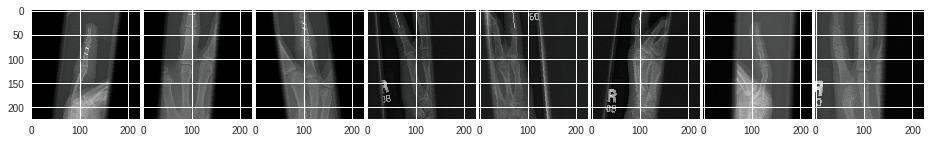

In [10]:
img, label = next(iter(transformed_train_dl))
#print(img, label.size())
fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 8), axes_pad=0.05)  
for i in range(img.size()[0]):
  #print(img)
  ax = grid[i]
  imshow(ax,img[i])
  print(label[i])

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
## This function just evaluate the loss / optimize  and returns model and the weight of the epoch which has highest accuracy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # In train phase they are settting 2 variable in model class - train() and schedular  = step()
        # In Validation phase setting the model class - eval()
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.# phase - train or validation
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.type(torch.cuda.LongTensor)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    #print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(phase,preds,labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            #print(preds[1:10],labels.data[1:10])
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        #print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def get_count(layer_name,model_name):
  ct  = 0 
  layer_count ={}
  for name, child in model_name.named_children():
      for name2, params in child.named_parameters():
        layer_count[name2] = ct
        ct +=1
  return layer_count[layer_name]

In [0]:
def freeze_till(layer_name,model_name):
  ct  = 0 
  count = get_count(layer_name,model_name)
  
  for name, child in model_name.named_children():
    for name2, params in child.named_parameters():
      
      if ct > count :
          
            params.requires_grad = True
      else :
            params.requires_grad = False
      ct +=1

In [19]:
# Load Pretrained model

#model_ft = models.resnet18(pretrained=True)
model_ft = models.densenet169(pretrained=True)

# Freeze specific layers of the model

freeze_till('transition2.conv.weight',model_ft)

# num_ftrs = model_ft.fc.in_features # fc for resnet
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()



# ------- Train all Parameters 
#Observe that all parameters are being optimized (passed) / we have updated all the layer in the resnet architecture by passing model_ft.parameters()
#to the optimizer , again SGD with momentum is preferred over Adam ?? 

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)


#----- Train last layer layers only 
#Observe that only parameters of final layer are being optimized as opoosed to before.

#'optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

#optimizer_ft = optim.Adam(model_ft.parameters(),betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


#----- Freeze specific layer and train only the unfreezed layers

#optimizer_ft = optim.SGD(list(filter(lambda p: p.requires_grad, model_ft.parameters())),lr=0.000001,momentum=0.9)

optimizer_ft = optim.Adam(list(filter(lambda p: p.requires_grad, model_ft.parameters())),lr = 0.0000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [16]:
dataloaders = {"train": transformed_train_dl, "val": transformed_valid_dl}
dataset_sizes = {"train": len(transformed_train_dataset),"val":len(transformed_valid_dataset)}
print(dataset_sizes)

{'train': 5106, 'val': 461}


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.7394 Acc: 0.4221
val Loss: 0.6871 Acc: 0.5553
Epoch 1/99
----------
train Loss: 0.7379 Acc: 0.4209
val Loss: 0.6836 Acc: 0.5531
Epoch 2/99
----------
train Loss: 0.7377 Acc: 0.4320
val Loss: 0.6946 Acc: 0.5813
Epoch 3/99
----------
train Loss: 0.7365 Acc: 0.4363
val Loss: 0.6841 Acc: 0.5575
Epoch 4/99
----------
train Loss: 0.7371 Acc: 0.4264
val Loss: 0.6959 Acc: 0.5249
Epoch 5/99
----------
train Loss: 0.7375 Acc: 0.4221
val Loss: 0.6903 Acc: 0.5553
Epoch 6/99
----------
train Loss: 0.7377 Acc: 0.4311
val Loss: 0.6822 Acc: 0.5705
Epoch 7/99
----------
train Loss: 0.7373 Acc: 0.4226
val Loss: 0.6946 Acc: 0.5380
Epoch 8/99
----------
train Loss: 0.7371 Acc: 0.4289
val Loss: 0.6858 Acc: 0.5857
Epoch 9/99
----------
train Loss: 0.7361 Acc: 0.4285
val Loss: 0.6916 Acc: 0.5466
Epoch 10/99
----------
train Loss: 0.7374 Acc: 0.4311
val Loss: 0.6903 Acc: 0.5727
Epoch 11/99
----------
train Loss: 0.7367 Acc: 0.4252
val Loss: 0.6949 Acc: 0.5271
Epoch 12/99
--

In [31]:
for name, child in model_ft.named_children():
    #print(name)
    #ct += 1
    
        for name2, params in child.named_parameters():
           
          print(name2,params.requires_grad)

conv0.weight False
norm0.weight False
norm0.bias False
denseblock1.denselayer1.norm1.weight False
denseblock1.denselayer1.norm1.bias False
denseblock1.denselayer1.conv1.weight False
denseblock1.denselayer1.norm2.weight False
denseblock1.denselayer1.norm2.bias False
denseblock1.denselayer1.conv2.weight False
denseblock1.denselayer2.norm1.weight False
denseblock1.denselayer2.norm1.bias False
denseblock1.denselayer2.conv1.weight False
denseblock1.denselayer2.norm2.weight False
denseblock1.denselayer2.norm2.bias False
denseblock1.denselayer2.conv2.weight False
denseblock1.denselayer3.norm1.weight False
denseblock1.denselayer3.norm1.bias False
denseblock1.denselayer3.conv1.weight False
denseblock1.denselayer3.norm2.weight False
denseblock1.denselayer3.norm2.bias False
denseblock1.denselayer3.conv2.weight False
denseblock1.denselayer4.norm1.weight False
denseblock1.denselayer4.norm1.bias False
denseblock1.denselayer4.conv1.weight False
denseblock1.denselayer4.norm2.weight False
denseblock1.d

In [28]:
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [1]:
!ls

datalab
